In [226]:
#link to dataset
#https://archive.ics.uci.edu/dataset/45/heart+disease
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

heart_disease = fetch_ucirepo(id=45)


X = heart_disease.data.features
y = heart_disease.data.targets

df = pd.concat([X, y], axis=1)

df.head()



,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [227]:
from sklearn.model_selection import train_test_split
#cleaning data

df = df.dropna()
df['target'] = (df['num'] > 0).astype(int)
df = df.drop(columns=['num'])

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2026)

categorical_cols = ['cp', 'restecg', 'slope', 'thal']
X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype=int)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype=int)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [228]:
from sklearn.linear_model import LogisticRegression

#model for logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)


base_rate = (y_test == 1).mean()
prediction_rate_LR = (y_test == pred_test).mean()

print(f"Base Rate: {base_rate:.2%}")
print(f"Model Accuracy for Logistic Regression: {prediction_rate_LR:.2%}")

Base Rate: 53.33%
Model Accuracy for Logistic Regression: 83.33%


In [229]:
from sklearn.metrics import confusion_matrix
# Create a specific DataFrame for Test Results only
# We copy X_test so we don't mess up the original data
test_results = X_test.copy()
test_results['y_true'] = y_test
test_results['pred_target'] = model.predict(X_test)


def get_test_rates(group):
    # Calculate confusion matrix for this specific group (e.g., just Women)

    tn, fp, fn, tp = confusion_matrix(group['y_true'], group['pred_target'], labels=[0, 1]).ravel()

    # Calculate the rates
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0

    return pd.Series({'FNR': fnr, 'FPR': fpr})

#Apply to Test Data grouped by Sex
test_rates_by_sex = test_results.groupby('sex').apply(get_test_rates)

print("--- Test Set Error Rates (Unseen Data) ---")
print(test_rates_by_sex)

--- Test Set Error Rates (Unseen Data) ---
          FNR       FPR
sex                    
0    0.400000  0.000000
1    0.181818  0.133333


/tmp/ipython-input-3044731702.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_rates_by_sex = test_results.groupby('sex').apply(get_test_rates)


In [230]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=2026)

#Train the model
model_rf.fit(X_train, y_train)

#  Make predictions
pred_train_rf = model_rf.predict(X_train)
pred_test_rf = model_rf.predict(X_test)

# Calculate Base Rate and Model Accuracy
base_rate_rf = (y_test == 1).mean()

# Prediction Rate: The percentage of correct guesses
prediction_rate_rf = (y_test == pred_test).mean()

print(f"Base Rate: {base_rate_rf:.2%}")
print(f"Model Accuracy for Random Forest: {prediction_rate_rf:.2%}")

Base Rate: 53.33%
Model Accuracy for Random Forest: 83.33%


In [231]:
#  Create a DataFrame for Random Forest Test Results ONLY
test_results_rf = X_test.copy()
test_results_rf['y_true'] = y_test
test_results_rf['pred_target_rf'] = pred_test_rf  # Using the predictions you already generated

#  Define the calculator function
def get_rf_rates(group):
    # Calculate confusion matrix for this specific group
    tn, fp, fn, tp = confusion_matrix(group['y_true'], group['pred_target_rf'], labels=[0, 1]).ravel()

    # Calculate rates
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0

    return pd.Series({'FNR': fnr, 'FPR': fpr})

#  Apply to Test Data grouped by Sex
rf_rates_by_sex = test_results_rf.groupby('sex').apply(get_rf_rates)

print("--- Random Forest Test Set Results ---")
print(rf_rates_by_sex)

--- Random Forest Test Set Results ---
          FNR  FPR
sex               
0    0.400000  0.0
1    0.272727  0.2


/tmp/ipython-input-671391473.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rf_rates_by_sex = test_results_rf.groupby('sex').apply(get_rf_rates)


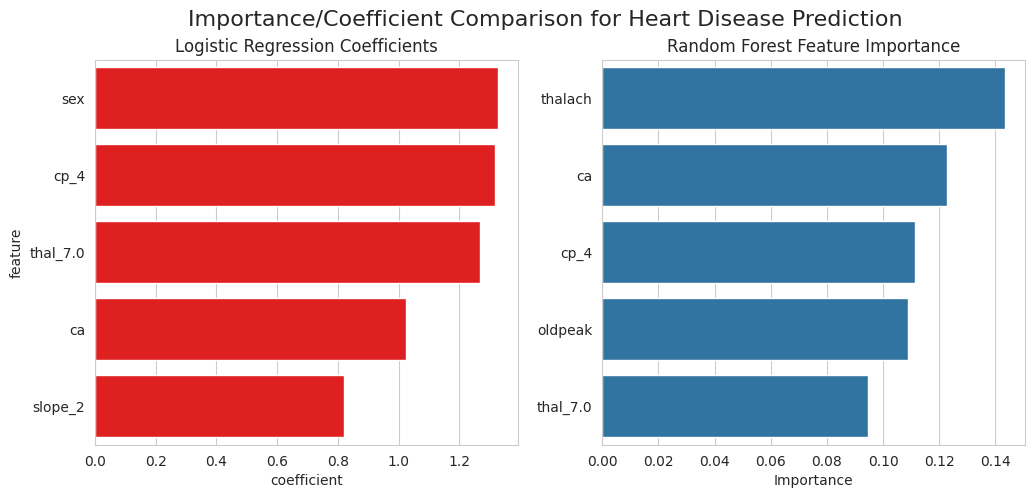

In [232]:
coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coefficient": model.coef_[0]
}).sort_values(by="coefficient", ascending=False)


# Extract importance scores
importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

fig, ax = plt.subplots(1,2, figsize = (12, 5))

fig.suptitle("Importance/Coefficient Comparison for Heart Disease Prediction", fontsize=16)
sns.barplot(coef_df.head(5), x = 'coefficient', y = 'feature', color = 'red', ax = ax[0])
ax[0].set_title("Logistic Regression Coefficients")
ax[0].set_ylabel("feature", fontsize = 10)

sns.barplot(data=importances.head(5), x='Importance', y='Feature', ax = ax[1])
ax[1].set_title("Random Forest Feature Importance")
ax[1].set_ylabel("")
plt.show()

#age 1 is male, 0 is female

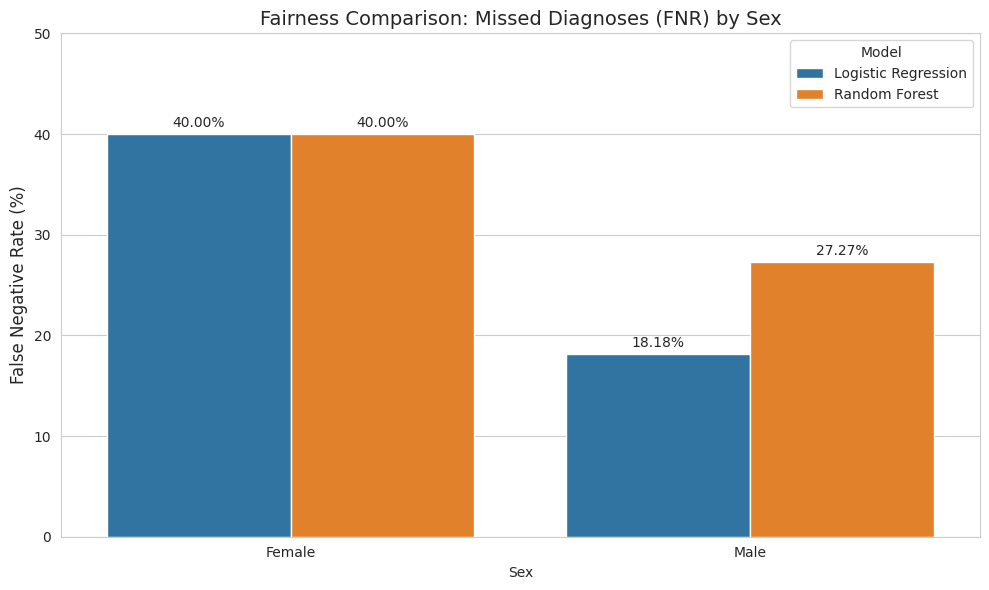

In [233]:

data = {
    'Sex': ['Female', 'Male'],
    'Logistic Regression': [
        test_rates_by_sex.loc[0, 'FNR'],
        test_rates_by_sex.loc[1, 'FNR']
    ],
    'Random Forest': [
        rf_rates_by_sex.loc[0, 'FNR'],
        rf_rates_by_sex.loc[1, 'FNR']
    ]
}


plot_data = pd.DataFrame(data)
plot_data = plot_data.melt(id_vars='Sex', var_name='Model', value_name='False Negative Rate')

sns.set_style("whitegrid")
plt.figure(figsize = (10,6))
plot_data['False Negative Rate'] = plot_data['False Negative Rate'] * 100

ax = sns.barplot(data=plot_data, x='Sex', y='False Negative Rate', hue = 'Model')
plt.title('Fairness Comparison: Missed Diagnoses (FNR) by Sex', fontsize=14)
plt.ylabel('False Negative Rate (%)', fontsize=12)
plt.ylim(0, 50)


for container in ax.containers:

    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=10)

plt.legend(title='Model')


plt.tight_layout()
plt.show()

Area Under Curve (AUC): 0.9118


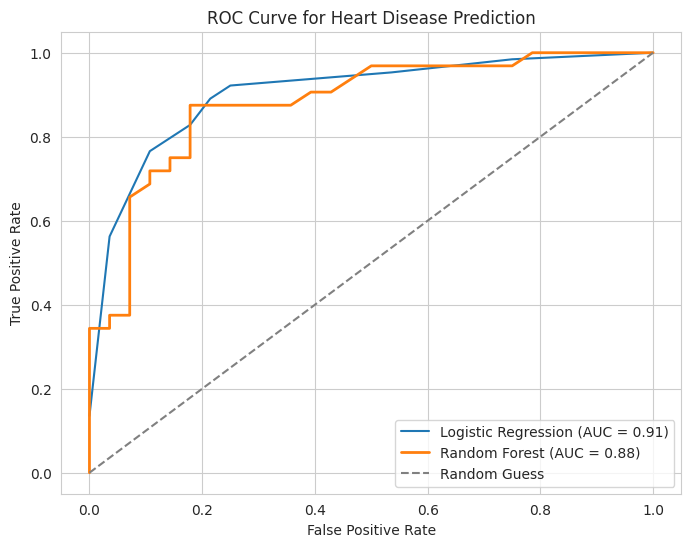

In [234]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get Probability Predictions for logistic regression
y_probs = model.predict_proba(X_test)[:, 1]

# Calculate ROC Metrics for logistic regression
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
print(f"Area Under Curve (AUC): {auc_score:.4f}")

y_probs_rf = model_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_probs_rf)
auc_rf = roc_auc_score(y_test, y_probs_rf)

roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr
})

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.lineplot(data=roc_df, x='False Positive Rate', y='True Positive Rate', label=f'Logistic Regression (AUC = {auc_score:.2f})', errorbar= None)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('ROC Curve for Heart Disease Prediction')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

 BEST THRESHOLD for Women: 0.17
   New FNR: 10.0% (Matches Men)
   New FPR: 7.7% (False Alarms)


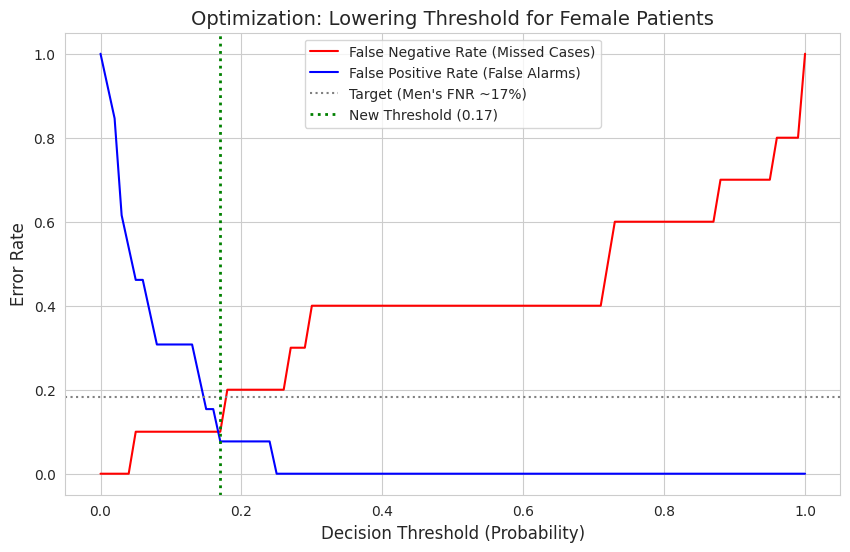

In [235]:
y_probs = model.predict_proba(X_test)[:, 1]
test_data = X_test.copy()
test_data['y_true'] = y_test
test_data['prob_disease'] = y_probs

women_df = test_data[test_data['sex'] == 0]

thresholds = np.linspace(0, 1, 101)
results = []

for t in thresholds:
    preds = (women_df['prob_disease'] > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(women_df['y_true'], preds, labels=[0, 1]).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0

    results.append({'Threshold': t, 'FNR': fnr, 'FPR': fpr})

df_results = pd.DataFrame(results)

#chose 0.1818 because that is the male FNR
candidate = df_results[df_results['FNR'] <= 0.1818].tail(1)


best_t = candidate.iloc[0]['Threshold']
best_fnr = candidate.iloc[0]['FNR']
best_fpr = candidate.iloc[0]['FPR']
print(f" BEST THRESHOLD for Women: {best_t:.2f}")
print(f"   New FNR: {best_fnr:.1%} (Matches Men)")
print(f"   New FPR: {best_fpr:.1%} (False Alarms)")


# 4. Plot the Graph
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(data=df_results, x='Threshold', y='FNR', label='False Negative Rate (Missed Cases)', color='red')

sns.lineplot(data=df_results, x='Threshold', y='FPR', label='False Positive Rate (False Alarms)', color='blue')


plt.title('Optimization: Lowering Threshold for Female Patients', fontsize=14)
plt.xlabel('Decision Threshold (Probability)', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)
plt.axhline(y=0.1818, color='grey', linestyle=':', label="Target (Men's FNR ~17%)")
plt.axvline(x=best_t, color='green', linestyle=':', linewidth=2, label='New Threshold (0.17)')
plt.legend()
plt.show()

Random Forest Baseline FNR for Men: 27.3%
 BEST THRESHOLD for Women (RF): 0.31
   New FNR: 20.0% (Matches Men's 27.3%)
   New FPR: 7.7% (False Alarms)


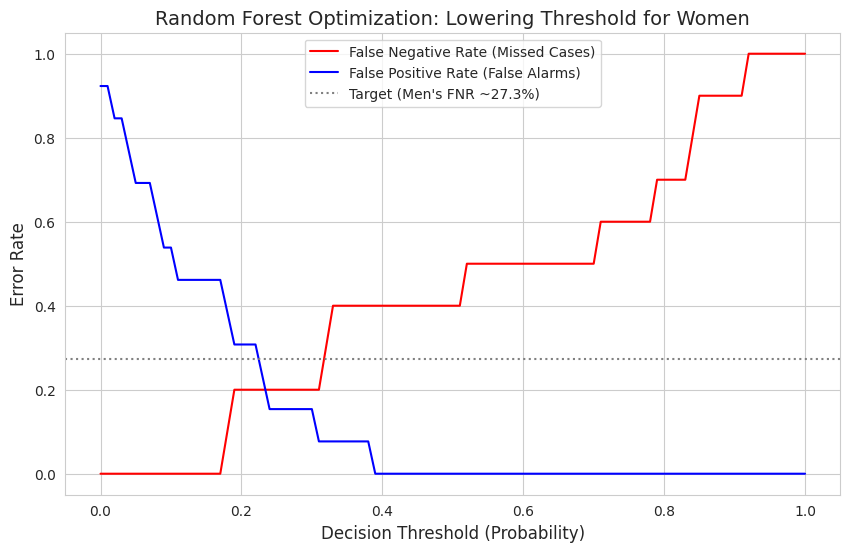

In [ ]:


#  Get Probabilities (The "Confidence" scores)
# predict_proba gives the % of trees that voted "Sick"
y_probs_rf = model_rf.predict_proba(X_test)[:, 1]

# Setup Data for Analysis
test_data = X_test.copy()
test_data['y_true'] = y_test
test_data['prob_disease'] = y_probs_rf
test_data['pred_default'] = model_rf.predict(X_test) # The standard 0.5 cutoff predictions



male_fnr_rf = rf_rates_by_sex.loc[1, 'FNR']

print(f"Random Forest Baseline FNR for Men: {male_fnr_rf:.1%}")

# 4.
women_df = test_data[test_data['sex'] == 0]
thresholds = np.linspace(0, 1, 101)
results = []

for t in thresholds:
    preds = (women_df['prob_disease'] > t).astype(int)
    tn, fp, fn, tp = confusion_matrix(women_df['y_true'], preds, labels=[0, 1]).ravel()

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (tn + fp) if (tn + fp) > 0 else 0

    results.append({'Threshold': t, 'FNR': fnr, 'FPR': fpr})

df_results = pd.DataFrame(results)

# Find match for the NEW male baseline
# We look for where Women's FNR <= Men's RF FNR
candidate = df_results[df_results['FNR'] <= male_fnr_rf].tail(1)

if not candidate.empty:
    best_t = candidate.iloc[0]['Threshold']
    best_fnr = candidate.iloc[0]['FNR']
    best_fpr = candidate.iloc[0]['FPR']
    print(f" BEST THRESHOLD for Women (RF): {best_t:.2f}")
    print(f"   New FNR: {best_fnr:.1%} (Matches Men's {male_fnr_rf:.1%})")
    print(f"   New FPR: {best_fpr:.1%} (False Alarms)")
else:
    print("No threshold found that exactly matches male performance.")

# 6. Plot the Graph
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lineplot(data=df_results, x='Threshold', y='FNR', label='False Negative Rate (Missed Cases)', color='red')
sns.lineplot(data=df_results, x='Threshold', y='FPR', label='False Positive Rate (False Alarms)', color='blue')

plt.title('Random Forest Optimization: Lowering Threshold for Women', fontsize=14)
plt.xlabel('Decision Threshold (Probability)', fontsize=12)
plt.ylabel('Error Rate', fontsize=12)

plt.axhline(y=male_fnr_rf, color='grey', linestyle=':', label=f"Target (Men's FNR ~{male_fnr_rf:.1%})")
plt.legend()
plt.show()